# survey

> This module handles observation targets, survey duration, and other similar functionality. Currently only for MW surveys.

In [ ]:
#| default_exp survey

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np
import pandas as pd
from LensCalcPy.pbh import *
from LensCalcPy.ffp import *
from LensCalcPy.utils import *
from LensCalcPy.parameters import *
from LensCalcPy.galaxy import *
import astropy.coordinates as coord
from astropy import units
import matplotlib.pyplot as plt

In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#| export
class Survey:
    """
    A class to represent a survey.
    """

    def __init__(self, 
                 l:float, # Galactic longitude in degrees
                 b: float, # Galactic latitude in degrees
                 source_dist:float, # Distance to observation source in kpc
                 obs_time: float, # Observation time in hours
                 cadence: float, # Cadence in hours
                 survey_area: float, # Survey area in deg^2
                 n_sources: int, # Number of sources observed in survey
                 efficiency: lambda x: 1, # Efficiency of survey
                 use_mw_source: bool = False, # Use Milky Way as source
                 mw_model: MilkyWayModel = None,
                 m31_model: M31Model = None, 
                 A_t: float = 1.34, # Threshold magnification for detection
                 ):
     
        self.l = l 
        self.b = b 
        self.source_dist = source_dist 
        self.obs_time = obs_time 
        self.cadence = cadence
        self.survey_area = survey_area
        self.pbh = None # PBH population
        self.ffp = None # FFP population
        self.n_sources = n_sources # Number of sources observed in the Milky Way
        self.efficiency = efficiency #! want to be a function of t
        self.use_mw_source = use_mw_source
        self.mw_model = mw_model or MilkyWayModel(mw_parameters)
        self.m31_model = m31_model or M31Model(m31_parameters)
        self.A_t = A_t
        self.u_t = u_t_point(self.A_t) #threshold impact parameter

    def __str__(self) -> str:
        return f"Survey(l={self.l}, b={self.b}, source_dist={self.source_dist}, obs_time={self.obs_time}, cadence = {self.cadence}, survey_area={self.survey_area}, n_sources={self.n_sources}, efficiency={self.efficiency})"
    __repr__ = __str__
    
    
    def add_pbh(self, 
                m_pbh: float = 1, # mass of each PBH in solar masses
                f_dm: float = 1, # fraction of DM in PBHs
                ):
        """adds a PBH population to the survey"""
        self.pbh = Pbh(m_pbh, f_dm, l=self.l, b=self.b, u_t=self.u_t, ds=self.source_dist)
        return
    
    def add_ffp(self,
                p: float, # power law index of FFP mass function
                ):
        """adds a FFP population to the survey"""
        self.ffp = Ffp(p, l=self.l, b=self.b, u_t=self.u_t, ds=self.source_dist)
    
    def get_crossing_times_rates_pbh(self,
                                    t_es: np.ndarray,
                                    finite: bool = False,
                                    ) -> np.ndarray:
        if self.pbh is None:
            raise ValueError("PBH population not defined")
        
        return self.pbh.compute_differential_rate(t_es, finite=finite)
    
    def get_crossing_times_rates_ffp(self,
                                    t_es: np.ndarray,
                                    finite: bool = False,
                                    ) -> np.ndarray:
        if self.ffp is None:
            raise ValueError("FFP population not defined")
        
        return self.ffp.compute_differential_rate(t_es, finite=finite)
    
    def get_crossing_time_rates(self,
                                t_es: np.ndarray,
                                finite: bool = False,
                                ) -> np.ndarray:
        """returns an array of crossing times"""
        
        rates_pbh = np.array(self.get_crossing_times_rates_pbh(t_es, finite=finite))
        rates_ffp = np.array(self.get_crossing_times_rates_ffp(t_es, finite=finite))
    
        #return separately for testing
        return rates_pbh, rates_ffp

    def get_events_observed_pbh(self,
                                t_es: np.ndarray,
                                finite: bool = False,
                                ) -> np.ndarray:
        
        rates_pbh = np.array(self.get_crossing_times_rates_pbh(t_es, finite=finite))
        num_pbh_obs = rates_pbh * self.n_sources * self.obs_time * t_es

        return num_pbh_obs

    def get_events_observed(self,
                            t_es: np.ndarray,
                            ) -> np.ndarray:

        
        rates_pbh, rates_ffp = self.get_crossing_time_rates(t_es)
        
        num_pbh_obs = rates_pbh * self.n_sources * self.obs_time * t_es
        num_ffp_obs = rates_ffp * self.n_sources * self.obs_time * t_es
        
        return num_pbh_obs, num_ffp_obs
    


### Efficiency Estimation

In [ ]:
m_pbh = 1e-5
f_dm = 1
p = 1

s1 = Survey(l, b, ds, obs_time, survey_area, n_sources=n_sources, survey_area=survey_area, efficiency=lambda t: 0.6, A_t = 1.1)
s2 = Survey(l, b, ds, obs_time, survey_area, n_sources=n_sources, survey_area=survey_area, efficiency=lambda t: 0.6, A_t = 1.34)
# s.add_pbh(m_pbh, f_dm)
s1.add_ffp(p)
s2.add_ffp(p)


In [ ]:
t_es = np.logspace(-2, 2, 10)
ffp_rates1 = s1.get_crossing_times_rates_ffp(t_es, finite=False)
ffp_rates2 = s2.get_crossing_times_rates_ffp(t_es, finite=False)

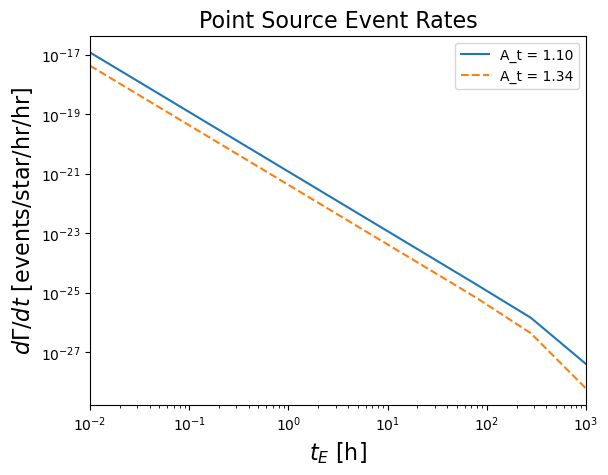

In [ ]:
# plt.loglog(t_es, pbh_rates, label="PBH")
plt.loglog(t_es, ffp_rates1, label=f"A_t = {s1.A_t:.2f}")
plt.loglog(t_es, ffp_rates2, label=f"A_t = {s2.A_t:.2f}", linestyle="--")

plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)
plt.title("Point Source Event Rates", fontsize=16)

plt.xlim(1e-2, 1e3)
# plt.ylim(1e-25, 1e-7)

plt.legend()
plt.show()

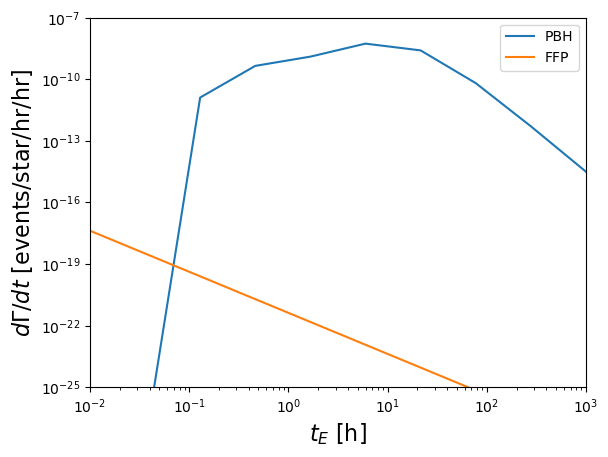

In [ ]:
# plt.loglog(t_es, pbh_rates, label="PBH")
plt.loglog(t_es, ffp_rates1, label="A_t = {s1.A_t:.2f}")
plt.loglog(t_es, ffp_rates2, label="A_t = {s2.A_t:.2f}")

plt.xlabel(r"$t_E$ [h]", fontsize=16)
plt.ylabel(r"$d\Gamma/dt$ [events/star/hr/hr]", fontsize=16)

plt.xlim(1e-2, 1e3)
# plt.ylim(1e-25, 1e-7)

plt.legend()
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()